#Basic Text classification using PySpark ML Pipeline

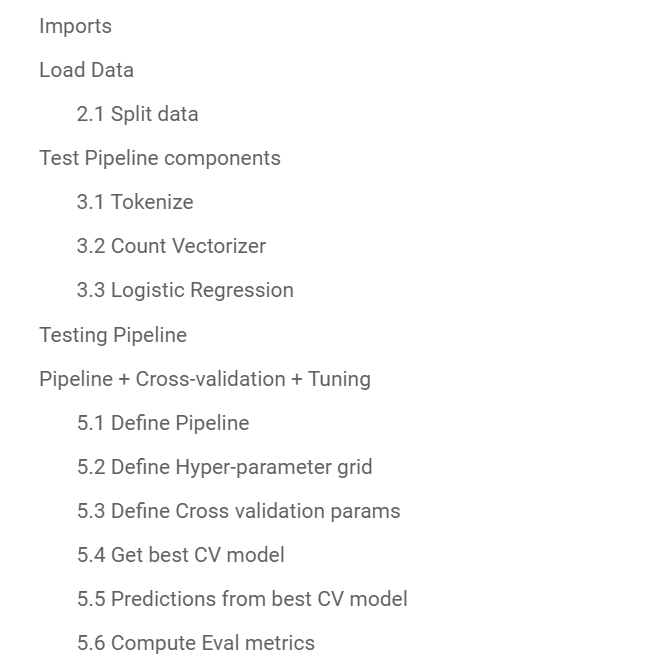

## 1. Imports

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer, Tokenizer, StringIndexer
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark import pandas as ps
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import classification_report

In [ ]:
spark = SparkSession.builder.getOrCreate()

## 2. Load Data

In [ ]:
# Load file
data_sparkdf = df1 = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/leena.khote@unilever.com/ecommerceDataset_v2.csv")

In [ ]:
data_sparkdf.printSchema()

root
-- prod_category: string (nullable = true)
-- prod_title_desc: string (nullable = true)

In [ ]:
data_sparkdf.show(2)

+-------------+--------------------+
prod_category| prod_title_desc|
+-------------+--------------------+
 Household|Paper Plane Desig...|
 Household|SAF 'Floral' Fram...|
+-------------+--------------------+
only showing top 2 rows

In [ ]:
data_sparkdf.dtypes

Out[31]: [('prod_category', 'string'), ('prod_title_desc', 'string')]

In [ ]:
data_sparkdf.select('prod_category').distinct().collect()

Out[32]: [Row(prod_category='Household'),
 Row(prod_category=' When I heard of a concept that could make Soda right at home using Co2'),
 Row(prod_category=' Bubbles makes plain water so much more fun to drink'),
 Row(prod_category=' Our Sodamakers is designed in Turin'),
 Row(prod_category=' home. You can also add fizz to your home made fresh juice or to any beverage that tastes better with soda. HOW DOES IT WORK Fill cold water into the reusable BPA-Free Mr. Butler Bottle'),
 Row(prod_category=" turn plain drinking water into fresh sparkling fizzy soda within seconds! What's more..you can add your soft drink flavours from brands such as Rasna and Tang to make your own fizzy soft drinks at "),
 Row(prod_category=' The Sodamaker plays a direct role in protecting our planet from plastic waste. By using a Sodamaker to make Soda and Soft Drinks at home'),
 Row(prod_category=' Over time'),
 Row(prod_category=' In addition to the convenience aspects of the product'),
 Row(prod_category=' You can be sure of the quality of water used as you control that. '),
 Row(prod_category=' Almost everybody likes fizz and what better way than to make it in seconds at home using Co2 which does no harm to your health and using clean water from your own source. Sparkling water also makes people drink more water which is good for their health. What makes your product special? I am immensely proud to make a product that has not just one'),
 Row(prod_category='Books'),
 Row(prod_category=' Growing up in the South'),
 Row(prod_category=' This is a multifaceted portrait of Muhammad Ali only he could render: sports legend; unapologetic anti-war advocate; outrageous showman and gracious goodwill ambassador; fighter'),
 Row(prod_category=' Who better to tell the tale than the man who went the distance living it?"'),
 Row(prod_category='Clothing & Accessories'),
 Row(prod_category='Electronics'),
 Row(prod_category=' In our business model'),
 Row(prod_category=' What has been the best part of your startup experience? In this dynamic start-up industry'),
 Row(prod_category=' Combined with a IPX4 Sweat/Dust/Splash Resistant design'),
 Row(prod_category=' Music the way it should be Bluetooth 4.1 technology features stable signal transmission'),
 Row(prod_category=' Submerge yourself in the limitless world of sound with the latest in Bluetooth innovation')]

In [ ]:
data_sparkdf = data_sparkdf.filter((data_sparkdf.prod_category  == "Household") | (data_sparkdf.prod_category  == "Books") |(data_sparkdf.prod_category  == "Clothing & Accessories") | (data_sparkdf.prod_category  == "Electronics"))
data_sparkdf = data_sparkdf.filter(data_sparkdf.prod_title_desc.isNotNull())

In [ ]:
data_sparkdf.select('prod_category').distinct().collect()

Out[34]: [Row(prod_category='Household'),
 Row(prod_category='Books'),
 Row(prod_category='Clothing & Accessories'),
 Row(prod_category='Electronics')]

### 2.1 Split data

In [ ]:
### Split data into Train & Test [90%,10%]
train_sparkdf, test_sparkdf = data_sparkdf.randomSplit([0.9, 0.1], seed=123)

In [ ]:
print((train_sparkdf.count(), len(train_sparkdf.columns)))

(45450, 2)

## 3. Test Pipeline components

### 3.1 Tokenize

In [ ]:
### Tokenize
tokenizer = Tokenizer(inputCol="prod_title_desc", outputCol="words")
data_token_sparkdf = tokenizer.transform(data_sparkdf)

In [ ]:
data_token_sparkdf.show(2)

+-------------+--------------------+--------------------+
prod_category| prod_title_desc| words|
+-------------+--------------------+--------------------+
 Household|Paper Plane Desig...|[paper, plane, de...|
 Household|SAF 'Floral' Fram...|[saf, 'floral', f...|
+-------------+--------------------+--------------------+
only showing top 2 rows

In [ ]:
data_token_sparkdf.dtypes

Out[10]: [('prod_category', 'string'),
 ('prod_title_desc', 'string'),
 ('words', 'array<string>')]

### 3.2 Count Vectorizer

In [ ]:
countVect = CountVectorizer(inputCol="words", outputCol="features", minDF=2.0,vocabSize=10000)
cv_model = countVect.fit(data_token_sparkdf)

In [ ]:
data_cv_sparkdf = cv_model.transform(data_token_sparkdf)

### 3.3 Logistic Regression

In [ ]:
### Label conversion into numerical varaible
indexer = StringIndexer(inputCol='prod_category', outputCol='label').fit(data_cv_sparkdf)
data_label_sparkdf = indexer.transform(data_cv_sparkdf)

In [ ]:
data_label_sparkdf.select('label').distinct().collect()

Out[24]: [Row(label=0.0), Row(label=1.0), Row(label=3.0), Row(label=2.0)]

In [ ]:
lr = LogisticRegression(maxIter=10, regParam=0.001)
lr.fit(data_label_sparkdf)
lr

Out[27]: LogisticRegression_bfbbe327c845

## 4. Testing Pipeline

In [ ]:
### Tokenize text
tokenizer = Tokenizer(inputCol="prod_title_desc", outputCol="words")
### Count Vectorizer BOW
countVect = CountVectorizer(inputCol="words", outputCol="features", minDF=2.0,vocabSize=10000)
### Label column encoding
indexer = StringIndexer(inputCol='prod_category', outputCol='label')
### Logistic regression model
lr = LogisticRegression(maxIter=10, regParam=0.001)

### Define pipeline
pipeline = Pipeline(stages=[tokenizer,countVect,indexer,lr])


In [ ]:
# Fit the pipeline to training documents.
model = pipeline.fit(train_sparkdf)

In [ ]:
result_sparkdf = model.transform(test_sparkdf).select("features","prod_category", "label", "prediction","probability")
result_sparkdf.show(10)
result_df = result_sparkdf.toPandas()

+--------------------+-------------+-----+----------+--------------------+
 features|prod_category|label|prediction| probability|
+--------------------+-------------+-----+----------+--------------------+
(10000,[1,3,4,5,7...| Household| 0.0| 3.0|[0.00471424386701...|
(10000,[1,2,3,4,6...| Household| 0.0| 0.0|[0.99999403516901...|
(10000,[0,3,4,14,...| Household| 0.0| 0.0|[0.96416381781802...|
(10000,[1,2,3,4,5...| Household| 0.0| 0.0|[0.99999997175618...|
(10000,[19,33,53,...| Household| 0.0| 0.0|[0.92478902151797...|
(10000,[19,30,33,...| Household| 0.0| 0.0|[0.82983652466793...|
(10000,[1,2,3,5,6...| Household| 0.0| 0.0|[0.99717141083608...|
(10000,[0,1,3,4,5...| Household| 0.0| 0.0|[0.99992659267039...|
(10000,[53,64,554...| Household| 0.0| 0.0|[0.64282030231556...|
(10000,[0,2,5,6,7...| Household| 0.0| 0.0|[0.99994596219883...|
+--------------------+-------------+-----+----------+--------------------+
only showing top 10 rows

In [ ]:
print(classification_report(result_df.label, result_df.prediction))
# result_df

precision recall f1-score support

 0.0 0.98 0.96 0.97 1924
 1.0 0.94 0.98 0.96 1190
 2.0 0.97 0.96 0.96 1033
 3.0 0.97 0.97 0.97 827

 accuracy 0.97 4974
 macro avg 0.96 0.97 0.97 4974
weighted avg 0.97 0.97 0.97 4974

## 5. Pipeline + Cross-validation + Tuning

### 5.1 Define Pipeline

In [ ]:
### Tokenize text
tokenizer = Tokenizer(inputCol="prod_title_desc", outputCol="words")
### Count Vectorizer BOW
countVect = CountVectorizer(inputCol="words", outputCol="features")
### Label column encoding
indexer = StringIndexer(inputCol='prod_category', outputCol='label')
### Logistic regression model
lr = LogisticRegression(maxIter=10)

### Define pipeline
pipeline = Pipeline(stages=[tokenizer,countVect,indexer,lr])


### 5.2 Define Hyper-parameter grid

In [ ]:
### Grid hyper parameter search
paramGrid = ParamGridBuilder() \
    .addGrid(countVect.minDF, [2.0, 5.0]) \
    .addGrid(countVect.vocabSize, [10000, 20000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

### 5.3 Define Cross validation params

In [ ]:
### Cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=5)

### 5.4 Get best CV model

In [ ]:
### Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train_sparkdf)

### 5.5 Predictions from best CV model

In [ ]:
### Make predictions on test documents. cvModel uses the best model found 
prediction = cvModel.transform(test_sparkdf).select("features","prod_category", "label", "prediction","probability")
prediction.show(10)

+--------------------+-------------+-----+----------+--------------------+
 features|prod_category|label|prediction| probability|
+--------------------+-------------+-----+----------+--------------------+
(20000,[1,3,4,5,7...| Household| 0.0| 0.0|[0.99202870896834...|
(20000,[1,2,3,4,6...| Household| 0.0| 0.0|[0.99675271271835...|
(20000,[0,3,4,14,...| Household| 0.0| 0.0|[0.91800144377381...|
(20000,[1,2,3,4,5...| Household| 0.0| 0.0|[0.99999841241047...|
(20000,[19,33,53,...| Household| 0.0| 0.0|[0.66360507267709...|
(20000,[19,30,33,...| Household| 0.0| 0.0|[0.52405290548940...|
(20000,[1,2,3,5,6...| Household| 0.0| 0.0|[0.93160616054168...|
(20000,[0,1,3,4,5...| Household| 0.0| 0.0|[0.99350208899459...|
(20000,[53,64,555...| Household| 0.0| 0.0|[0.48147301526557...|
(20000,[0,2,5,6,7...| Household| 0.0| 0.0|[0.99218608369846...|
+--------------------+-------------+-----+----------+--------------------+
only showing top 10 rows

### 5.6 Compute Eval metrics

In [ ]:
### Convert to Pandas DF to compute evaluation metrics
result_df = prediction.toPandas()
print(classification_report(result_df.label, result_df.prediction))

/databricks/spark/python/pyspark/sql/pandas/conversion.py:92: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)
 precision recall f1-score support

 0.0 0.98 0.97 0.98 1924
 1.0 0.96 0.98 0.97 1190
 2.0 0.97 0.96 0.97 1033
 3.0 0.99 0.97 0.98 827

 accuracy 0.97 4974
 macro avg 0.97 0.97 0.97 4974
weighted avg 0.97 0.97 0.97 4974